# Colapse all simulation into a unique .feather file

In [1]:
import glob, os
import pandas as pd
import numpy as np

os.chdir('/N/u/hlimadar/BigRed200/slate/grammar_samples/Sensitivity_Analysis')
os.getcwd()

df_complete_file = 'df_complete_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex3/SummaryFile_*.csv')
    df_all = pd.concat((pd.read_csv(file, sep='\t', encoding='utf-8') for file in data_files), ignore_index=True)
    df_all.to_feather(df_complete_file)
df_all # 6786560 rows = 2816 samples * 10 repplicates * 241 time points

df_complete_ex3.feather already exists. Reading it.


,Unnamed: 0,time,replicate,sample,runtime,tumor_live,tumor_dead,m2_live,m2_dead,dist_mean_tumor_live,...,persistence_tumor_hfm,persistence_tumor_hp,adhesion_tumor_sat,adhesion_tumor_hfm,adhesion_tumor_hp,speed_M2_hfm,speed_M2_hp,debris_M2_sat,debris_M2_hfm,debris_M2_hp
0,0,0.0,9,1426,0.000018,200,0,10,0,98.053367,...,1.964496,8.827315,0.199277,2.295689,9.187128,0.008890,4.524761,0.017427,0.097168,8.329903
1,0,30.0,9,1426,0.810916,199,1,10,0,98.428226,...,1.964496,8.827315,0.199277,2.295689,9.187128,0.008890,4.524761,0.017427,0.097168,8.329903
2,0,60.0,9,1426,1.758312,200,1,10,0,98.523727,...,1.964496,8.827315,0.199277,2.295689,9.187128,0.008890,4.524761,0.017427,0.097168,8.329903
3,0,90.0,9,1426,2.568978,201,1,10,0,98.203077,...,1.964496,8.827315,0.199277,2.295689,9.187128,0.008890,4.524761,0.017427,0.097168,8.329903
4,0,120.0,9,1426,3.366487,202,1,10,0,98.611681,...,1.964496,8.827315,0.199277,2.295689,9.187128,0.008890,4.524761,0.017427,0.097168,8.329903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786555,0,7080.0,9,1595,191.102904,218,10,6,0,153.921866,...,1.603970,9.786410,0.239367,2.134949,11.889603,0.009765,4.683039,0.014489,0.093499,8.858074
6786556,0,7110.0,9,1595,191.822652,215,12,6,0,154.731211,...,1.603970,9.786410,0.239367,2.134949,11.889603,0.009765,4.683039,0.014489,0.093499,8.858074
6786557,0,7140.0,9,1595,192.551885,215,12,6,0,154.936262,...,1.603970,9.786410,0.239367,2.134949,11.889603,0.009765,4.683039,0.014489,0.093499,8.858074
6786558,0,7170.0,9,1595,193.274332,216,12,6,0,154.870379,...,1.603970,9.786410,0.239367,2.134949,11.889603,0.009765,4.683039,0.014489,0.093499,8.858074


# Define the QoIs: AUC of each mean population, weithed mean and pooled std of distance from the center in the last time

- Invasion: Mean and std of cells' distance from the center - measures the average spread of cells and how spread out (variability) the invasion is.
    - Summary over time and replicates: For the last point, take the weighted mean of the means (weights: number of cells) and the pooled std from the stds.
- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.

In [2]:
df_summary_file = 'df_summary_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) ):
    print(f'{df_summary_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
else:
    print(f'{df_summary_file} does not exists. Generating it.')

    # Take the weighted mean and pooled std of replicates in each sample and time
    # Define the weighted mean function
    def weighted_mean(df, value_col, weight_col):
        return (df[value_col] * df[weight_col]).sum(skipna=True) / df[weight_col].sum(skipna=True)
    # Define the pooled standard deviation function
    def pooled_std(df, std_col, weight_col):
        variance = ((df[weight_col]-1) * df[std_col]** 2).sum(skipna=True) / (df[weight_col]-1).sum(skipna=True)
        return np.sqrt(variance)

    # Apply the weighted mean and pooled std to the desired columns
    pop_cols = ['tumor_live', 'tumor_dead', 'm2_live', 'm2_dead']
    mean_cols = ['dist_mean_tumor_live', 'dist_mean_tumor_dead', 'dist_mean_m2_live', 'dist_mean_m2_dead']
    std_cols = ['dist_std_tumor_live', 'dist_std_tumor_dead', 'dist_std_m2_live', 'dist_std_m2_dead']

    weighted_means = df_all.groupby(['sample', 'time']).apply(lambda x: pd.Series({f'weighted_mean_{col_wei}': weighted_mean(x, col_mean, col_wei) for col_mean, col_wei in zip(mean_cols,pop_cols)}))
    pooled_stds = df_all.groupby(['sample', 'time']).apply(lambda x: pd.Series({f'pooled_std_{col_wei}': pooled_std(x, col_std, col_wei) for col_std, col_wei in zip(std_cols,pop_cols)}))

    df_samples_mean = df_all.groupby(['sample', 'time'], as_index=False).mean()
    df_samples_mean = df_samples_mean.merge(weighted_means, on=['sample', 'time'])
    df_samples_mean = df_samples_mean.merge(pooled_stds, on=['sample', 'time'])
    df_samples_mean = df_samples_mean.drop(columns=['Unnamed: 0','replicate'])
    
    # Function to calculate AUC using trapezoidal rule for trajectories
    def calculate_auc_multiple(group):
        auc_values = {}
        columns = [col for col in df_samples_mean.columns if col.startswith('weighted_mean_')]
        for col in columns: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapezoid(group[col][mask_notna], group['time'][mask_notna])
        return pd.Series(auc_values)
    # Group by 'Sample_ID' then calculate AUC for each QOI
    df_auc = df_samples_mean.groupby(['sample']).apply(calculate_auc_multiple).reset_index() # calculate the AUC for each QOI
    
    # Filter the dataframe to last time point
    df_summary = df_samples_mean[ df_samples_mean['time'] == 7200.0 ]
    # Merge the AUC values of trajectories
    df_summary = df_summary.merge(df_auc, on=['sample'])

    df_summary.to_feather(df_summary_file)

df_summary

df_summary_ex3.feather already exists. Reading it.


,sample,time,runtime,tumor_live,tumor_dead,m2_live,m2_dead,dist_mean_tumor_live,dist_mean_tumor_dead,dist_mean_m2_live,...,weighted_mean_m2_live,weighted_mean_m2_dead,pooled_std_tumor_live,pooled_std_tumor_dead,pooled_std_m2_live,pooled_std_m2_dead,AUC_weighted_mean_tumor_live,AUC_weighted_mean_tumor_dead,AUC_weighted_mean_m2_live,AUC_weighted_mean_m2_dead
0,0,7200.0,229.659675,196.4,12.9,10.6,0.5,154.448264,138.048448,115.275163,...,116.254175,124.063036,75.390237,72.825928,64.169517,NaN,871058.134121,771883.245850,1.172293e+06,1.224108e+06
1,1,7200.0,221.156985,188.6,9.3,10.5,1.0,160.611808,155.240100,116.284738,...,115.706569,142.622554,76.656418,83.892051,55.136744,inf,892677.388889,794943.005095,1.136196e+06,1.215992e+06
2,2,7200.0,239.352220,190.7,9.0,10.3,0.5,155.044827,147.366132,115.985481,...,117.599032,123.565130,75.391561,75.978986,63.275751,NaN,878948.096432,790022.618033,1.157507e+06,1.165290e+06
3,3,7200.0,224.063772,188.2,8.7,10.9,0.2,158.612941,154.011637,126.436148,...,129.587871,95.816510,77.570801,76.621256,64.122871,-0.0,880692.308729,831219.778054,1.205543e+06,1.301357e+06
4,4,7200.0,224.033875,195.3,9.7,9.7,0.4,153.195098,126.903945,122.194333,...,128.224702,141.969551,74.805106,72.510358,61.018175,-0.0,879903.063450,812081.795867,1.184643e+06,1.046105e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,2811,7200.0,186.411203,206.3,7.2,10.1,0.4,152.543794,151.556780,133.269770,...,137.534231,159.283199,78.802611,74.729170,77.128786,-0.0,858969.188008,850878.131279,1.250163e+06,1.421761e+06
2812,2812,7200.0,185.850324,214.5,9.3,11.9,0.4,157.454854,159.178997,137.688504,...,137.081669,99.910631,79.123172,82.640643,67.903754,-0.0,872810.299210,828296.780334,1.232498e+06,1.072192e+06
2813,2813,7200.0,186.332335,207.1,6.5,10.3,0.9,142.711636,157.315441,140.601463,...,140.789516,127.536852,75.371799,70.329832,77.991883,NaN,834629.477431,842099.079966,1.282002e+06,1.296552e+06
2814,2814,7200.0,185.069573,202.4,8.3,10.4,0.3,146.541014,149.647061,132.556564,...,137.550519,237.988588,77.686194,71.465150,72.477784,NaN,848371.322993,846357.037861,1.222608e+06,1.299523e+06


Text(0.5, 0, 'Sample')

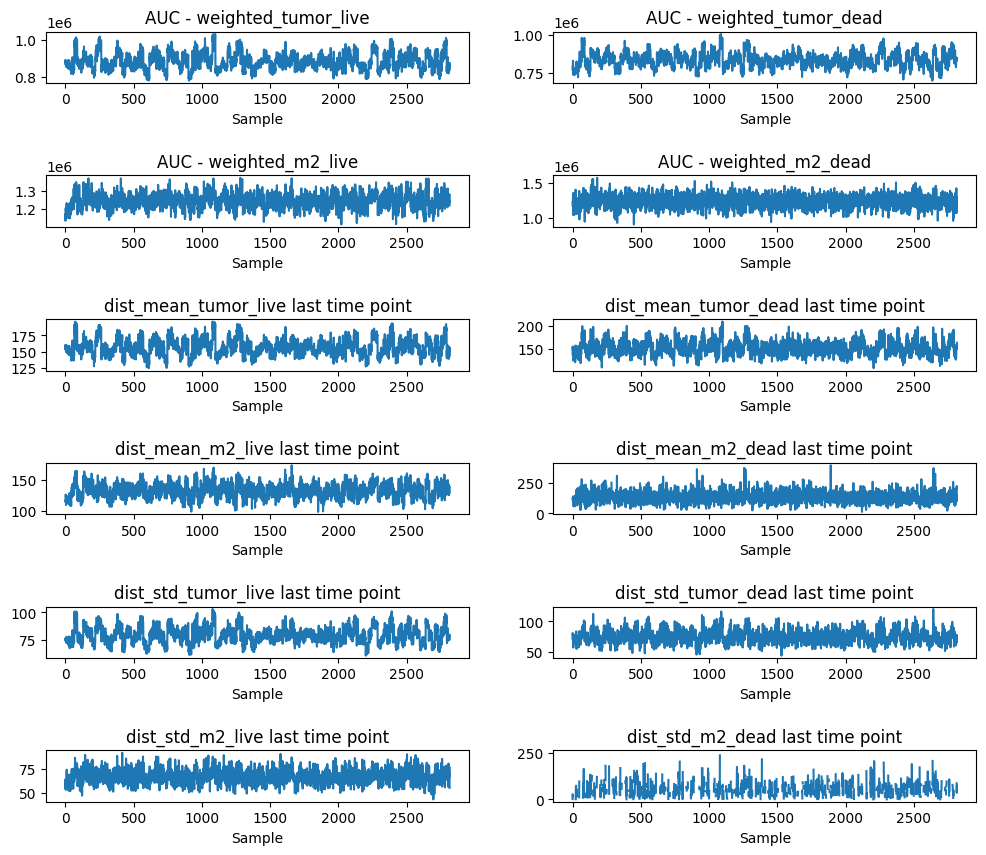

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=1.8)
axes[0, 0].plot(df_summary['sample'], df_summary['AUC_weighted_mean_tumor_live'])
axes[0, 0].set_title('AUC - weighted_tumor_live')
axes[0, 0].set_xlabel('Sample')
axes[0, 1].plot(df_summary['sample'], df_summary['AUC_weighted_mean_tumor_dead'])
axes[0, 1].set_title('AUC - weighted_tumor_dead')
axes[0, 1].set_xlabel('Sample')

axes[1, 0].plot(df_summary['sample'], df_summary['AUC_weighted_mean_m2_live'])
axes[1, 0].set_title('AUC - weighted_m2_live')
axes[1, 0].set_xlabel('Sample')
axes[1, 1].plot(df_summary['sample'], df_summary['AUC_weighted_mean_m2_dead'])
axes[1, 1].set_title('AUC - weighted_m2_dead')
axes[1, 1].set_xlabel('Sample')

axes[2, 0].plot(df_summary['sample'], df_summary['dist_mean_tumor_live'])
axes[2, 0].set_title('dist_mean_tumor_live last time point')
axes[2, 0].set_xlabel('Sample')
axes[2, 1].plot(df_summary['sample'], df_summary['dist_mean_tumor_dead'])
axes[2, 1].set_title('dist_mean_tumor_dead last time point')
axes[2, 1].set_xlabel('Sample')

axes[3, 0].plot(df_summary['sample'], df_summary['dist_mean_m2_live'])
axes[3, 0].set_title('dist_mean_m2_live last time point')
axes[3, 0].set_xlabel('Sample')
axes[3, 1].plot(df_summary['sample'], df_summary['dist_mean_m2_dead'])
axes[3, 1].set_title('dist_mean_m2_dead last time point')
axes[3, 1].set_xlabel('Sample')

axes[4, 0].plot(df_summary['sample'], df_summary['dist_std_tumor_live'])
axes[4, 0].set_title('dist_std_tumor_live last time point')
axes[4, 0].set_xlabel('Sample')
axes[4, 1].plot(df_summary['sample'], df_summary['dist_std_tumor_dead'])
axes[4, 1].set_title('dist_std_tumor_dead last time point')
axes[4, 1].set_xlabel('Sample')

axes[5, 0].plot(df_summary['sample'], df_summary['dist_std_m2_live'])
axes[5, 0].set_title('dist_std_m2_live last time point')
axes[5, 0].set_xlabel('Sample')
axes[5, 1].plot(df_summary['sample'], df_summary['dist_std_m2_dead'])
axes[5, 1].set_title('dist_std_m2_dead last time point')
axes[5, 1].set_xlabel('Sample')

# SA Convergence

In [4]:
from SALib.analyze import sobol
from SALib import ProblemSpec
from uq_physicell.uq_physicell import PhysiCell_Model, get_rule_index_in_csv
import os 

print(os.getcwd())
# Change the directory
os.chdir("/N/slate/hlimadar/grammar_samples")

PhysiCellModel = PhysiCell_Model("Sensitivity_Analysis/ConfigFile.ini", 'model_tam_egf')
# Define parameters of rules in range +/- 20% of the reference value
names_parameters = []
bounds_parameters = []
for key_rule, list_rule in PhysiCellModel.parameters_rules.items():
    id_rule = get_rule_index_in_csv(PhysiCellModel.rules, key_rule)
    parameter_rule = key_rule.split(',')[-1]
    names_parameters.append(list_rule[1])
    bounds_parameters.append([float(PhysiCellModel.rules[id_rule][parameter_rule])*0.8, float(PhysiCellModel.rules[id_rule][parameter_rule])*1.2])
    # id_rule, name, parametername (saturation, half max, or hill power), value of reference
    # print(id_rule, list_rule[1], parameter_rule, PhysiCellModel.rules[id_rule][parameter_rule])

# Define SA problem
problem = {'names': names_parameters, 'bounds': bounds_parameters}
sa_sobol = ProblemSpec(problem)

# Sample parameters 
sa_sobol.sample_sobol(2**6, calc_second_order=True, seed=42) # False: N*(D+2) True: N*(2D+2)

# Define a range of sample sizes
N = np.array([2**1, 2**2, 2**3, 2**4, 2**5, 2**6])
D = sa_sobol.samples.shape[1]
sample_sizes = N*(2*D+2) # False: N*(D+2) True: N*(2D+2)

dic_analyzes = {}
QOI_colums = [col for col in df_summary.columns if ( col.startswith('AUC_') | (col.startswith('dist_')) ) ]
print('QOIs: ', QOI_colums)
# Analyze the multiple QOIs
for col in QOI_colums:
    # Set the results
    sa_sobol.set_results(df_summary[col].to_numpy())
    # Example to plot the first-order indices over sample size
    S1_values = []  # Store first-order indices for each sample size
    ST_values = []  # Store total-order indices for each sample size
    
    # Run Sobol analysis for each sample size using subsets of the large sample set
    for samp_size in sample_sizes:
        # Take the first N samples from the large sample set
        param_values_subset = sa_sobol.samples[:samp_size]
        Y_subset = sa_sobol.results[:samp_size]
        # Perform Sobol analysis on the subset
        Si = sobol.analyze(problem, Y_subset, calc_second_order=True)#, print_to_console=True)
        # Storage results for comparison
        S1_values.append(Si['S1'])
        ST_values.append(Si['ST'])
    
    # Convert to NumPy arrays for plotting
    dic_analyzes[col] = {'S1_values': np.array(S1_values), 'ST_values': np.array(ST_values)}

/N/slate/hlimadar/grammar_samples/Sensitivity_Analysis
QOIs:  ['dist_mean_tumor_live', 'dist_mean_tumor_dead', 'dist_mean_m2_live', 'dist_mean_m2_dead', 'dist_std_tumor_live', 'dist_std_tumor_dead', 'dist_std_m2_live', 'dist_std_m2_dead', 'AUC_weighted_mean_tumor_live', 'AUC_weighted_mean_tumor_dead', 'AUC_weighted_mean_m2_live', 'AUC_weighted_mean_m2_dead']


/N/u/hlimadar/BigRed200/.conda/envs/dask_env/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


In [16]:
# Convert to DataFrame
dic_to_df = {
    'QOI': [],
    'S1': [],
    'ST': [],
    'sample_size': [],
    'parameter': [],
    'rule_label': [],
    'rule_parameter': []
}

dic_rules = {"cycle_tumor_hfm": "Rule 01", "cycle_tumor_hp": "Rule 01",
             "necrosis_tumor_hfm": "Rule 02", "necrosis_tumor_hp": "Rule 02",
             "debris_tumor_sat": "Rule 04", "debris_tumor_hfm": "Rule 04", "debris_tumor_hp": "Rule 04",
             "speed_tumor_sat": "Rule 06", "speed_tumor_hfm": "Rule 06", "speed_motile_tumor_hp": "Rule 06",
             "persistence_tumor_sat": "Rule 07", "persistence_tumor_hfm": "Rule 07", "persistence_tumor_hp": "Rule 07",
             "adhesion_tumor_sat": "Rule 08", "adhesion_tumor_hfm": "Rule 08", "adhesion_tumor_hp": "Rule 08",
             "speed_M2_hfm": "Rule 22", "speed_M2_hp": "Rule 22",
             "debris_M2_sat": "Rule 28", "debris_M2_hfm": "Rule 28", "debris_M2_hp": "Rule 28"}

for qoi in dic_analyzes.keys():
    for par_id in range(dic_analyzes[qoi]['S1_values'].shape[1]):
        for sample_id in range(dic_analyzes[qoi]['S1_values'].shape[0]):
            dic_to_df['QOI'].append(qoi)
            dic_to_df['S1'].append(dic_analyzes[qoi]['S1_values'][sample_id, par_id])
            dic_to_df['ST'].append(dic_analyzes[qoi]['ST_values'][sample_id, par_id])
            dic_to_df['sample_size'].append(sample_sizes[sample_id])
            dic_to_df['parameter'].append(problem['names'][par_id])
            dic_to_df['rule_label'].append(dic_rules[problem['names'][par_id]])
            dic_to_df['rule_parameter'].append(problem['names'][par_id].split('_')[-1])

df_analyzes = pd.DataFrame(dic_to_df)
df_analyzes

,QOI,S1,ST,sample_size,parameter,rule_label,rule_parameter
0,dist_mean_tumor_live,-0.549927,0.081205,88,cycle_tumor_hfm,Rule 01,hfm
1,dist_mean_tumor_live,-0.423732,0.122993,176,cycle_tumor_hfm,Rule 01,hfm
2,dist_mean_tumor_live,-0.257487,0.073598,352,cycle_tumor_hfm,Rule 01,hfm
3,dist_mean_tumor_live,-0.229361,0.084327,704,cycle_tumor_hfm,Rule 01,hfm
4,dist_mean_tumor_live,-0.159260,0.100711,1408,cycle_tumor_hfm,Rule 01,hfm
...,...,...,...,...,...,...,...
1507,AUC_weighted_mean_m2_dead,1.003025,0.907853,176,debris_M2_hp,Rule 28,hp
1508,AUC_weighted_mean_m2_dead,0.738949,1.996224,352,debris_M2_hp,Rule 28,hp
1509,AUC_weighted_mean_m2_dead,0.234635,1.465986,704,debris_M2_hp,Rule 28,hp
1510,AUC_weighted_mean_m2_dead,-0.051269,1.082251,1408,debris_M2_hp,Rule 28,hp


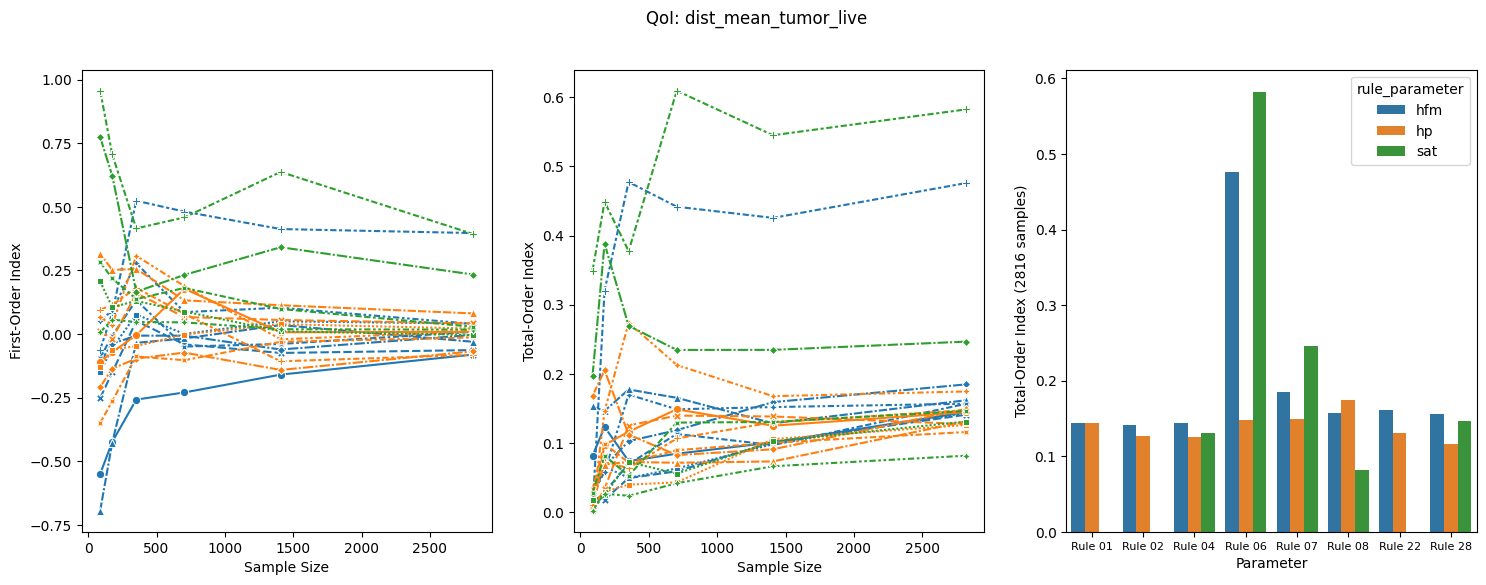

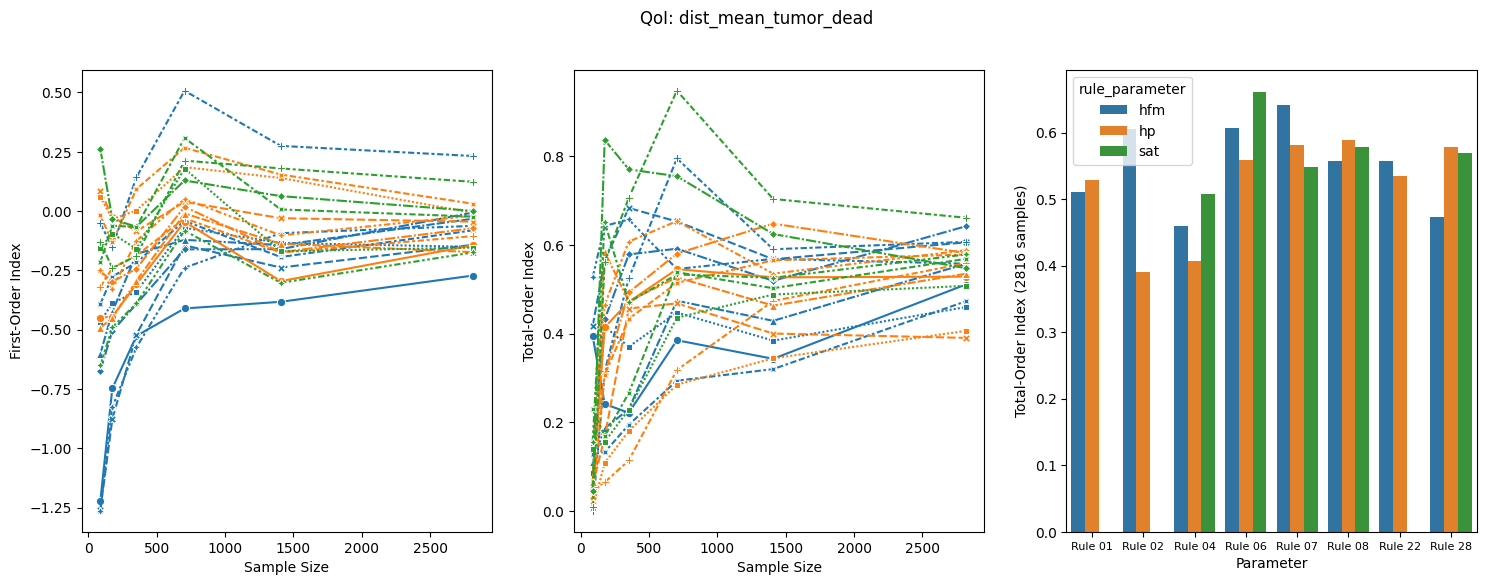

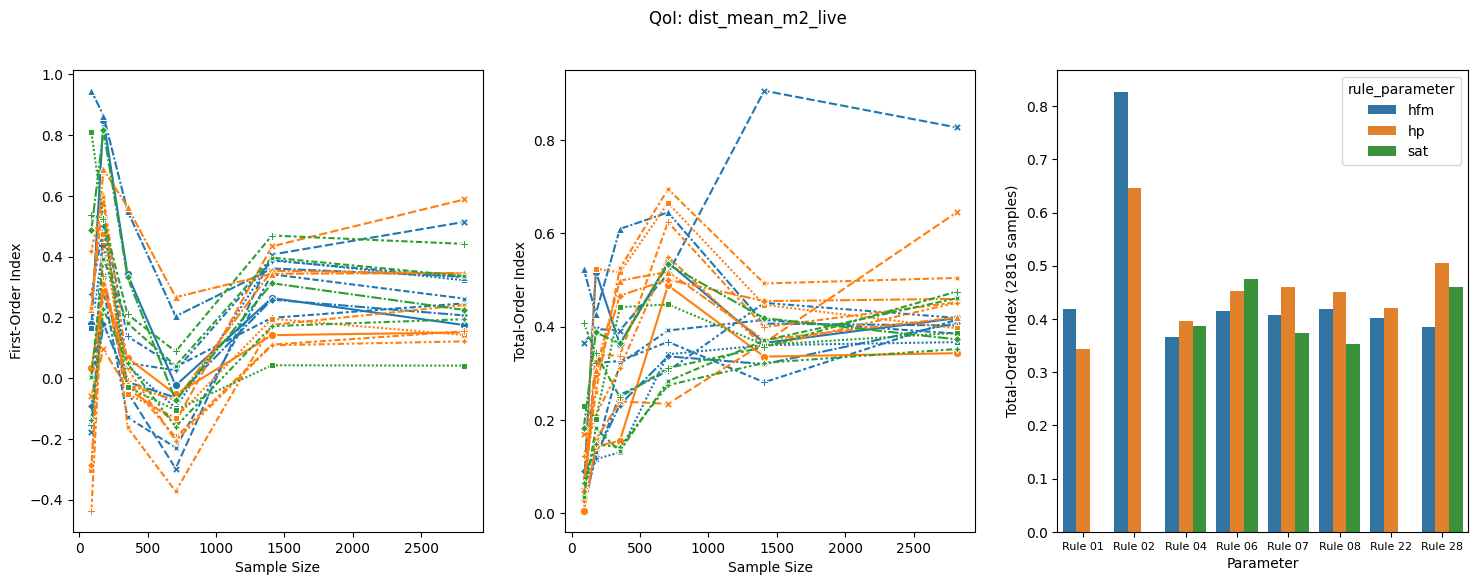

QoI: dist_mean_m2_dead has NaN values


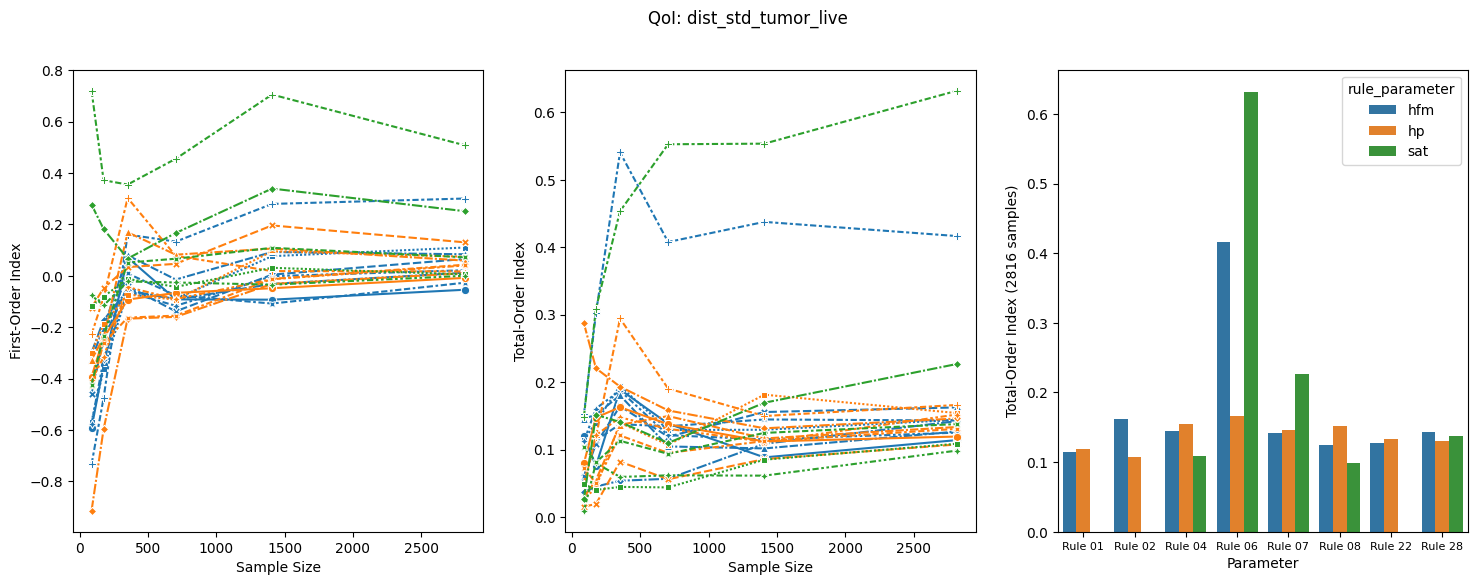

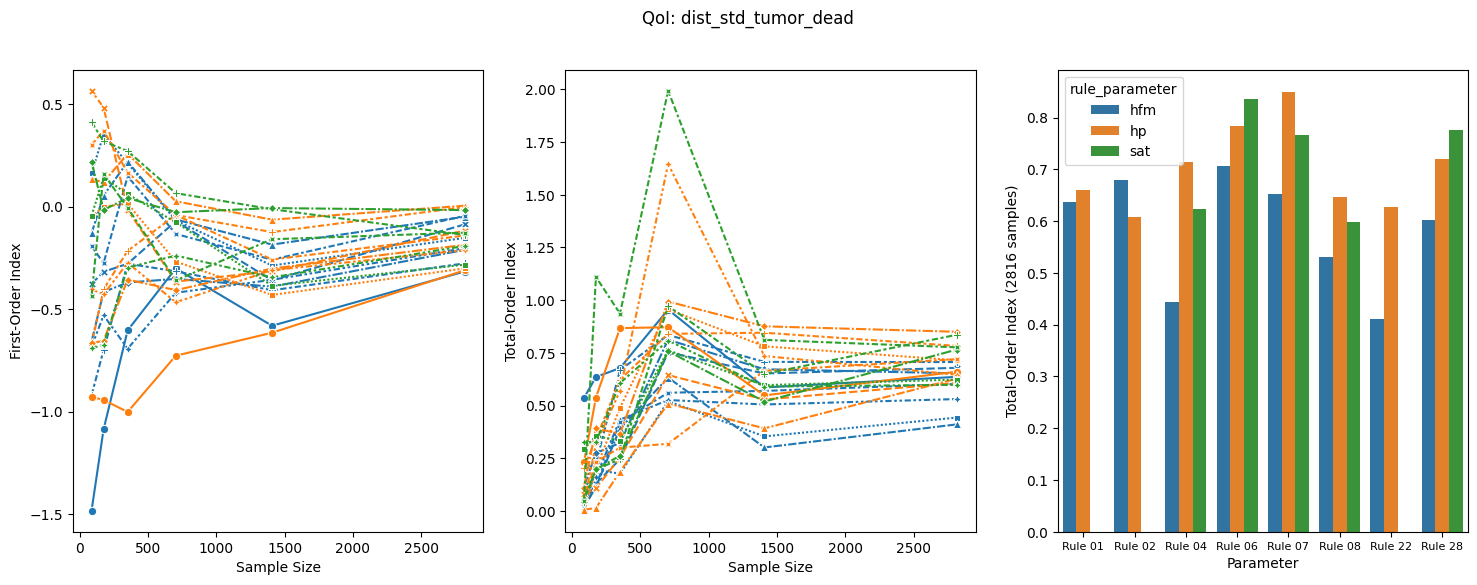

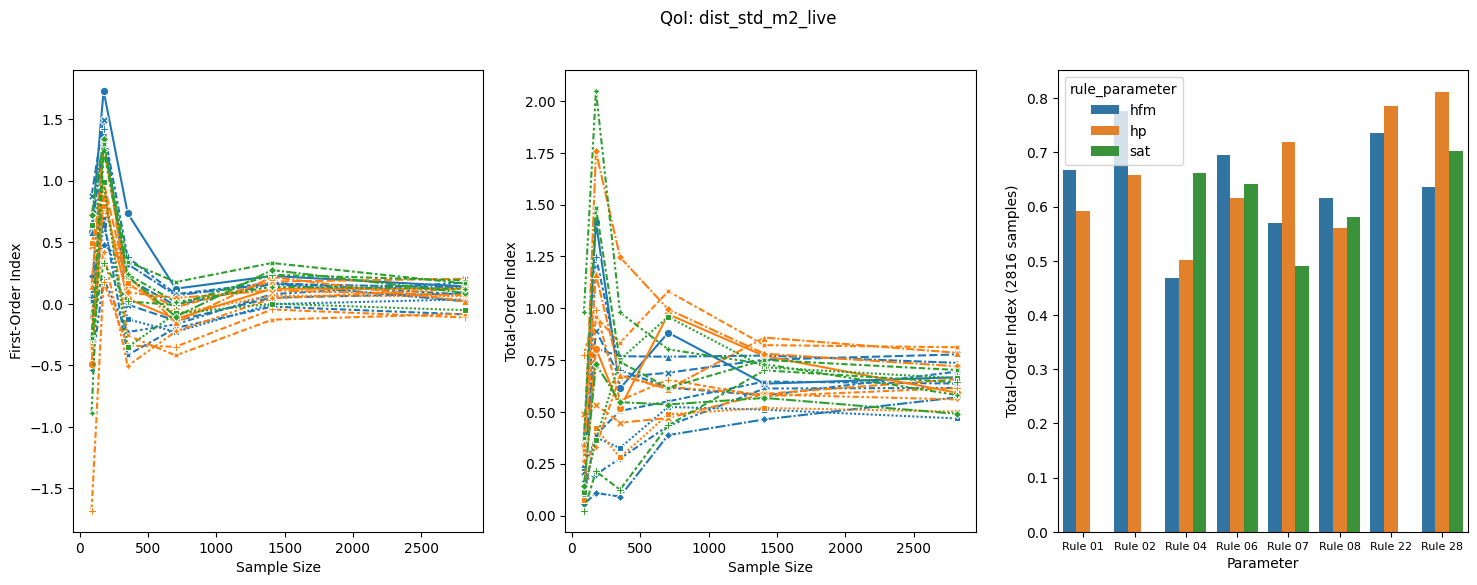

QoI: dist_std_m2_dead has NaN values


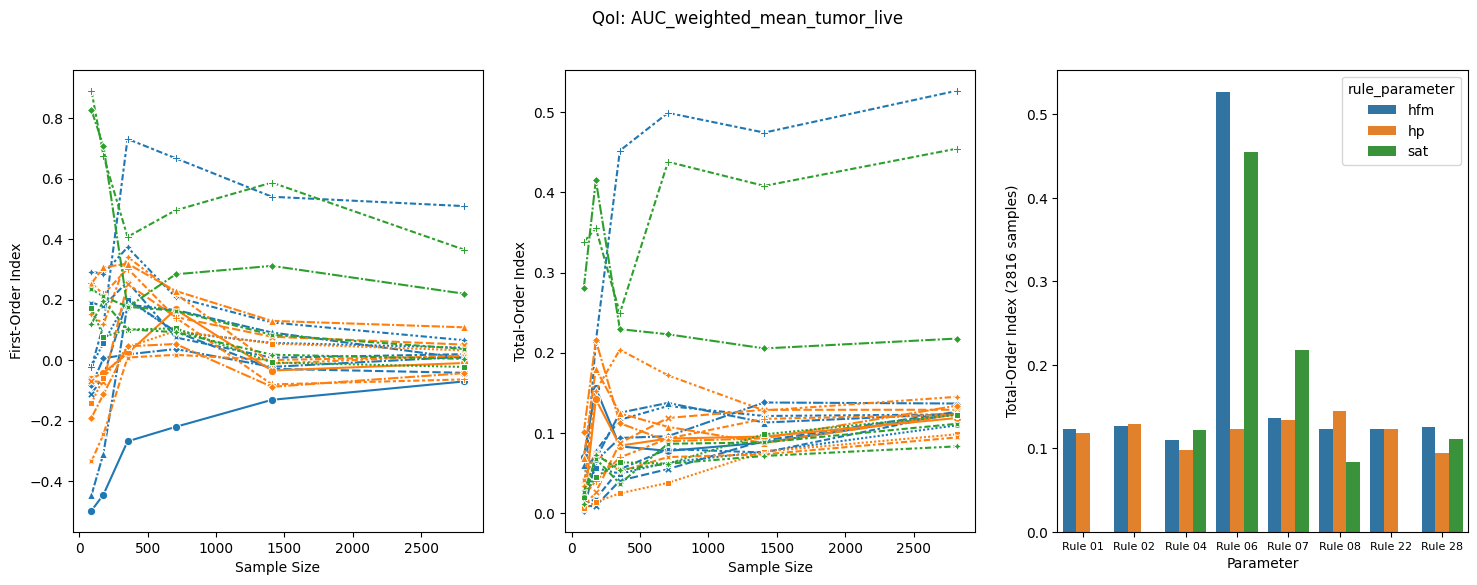

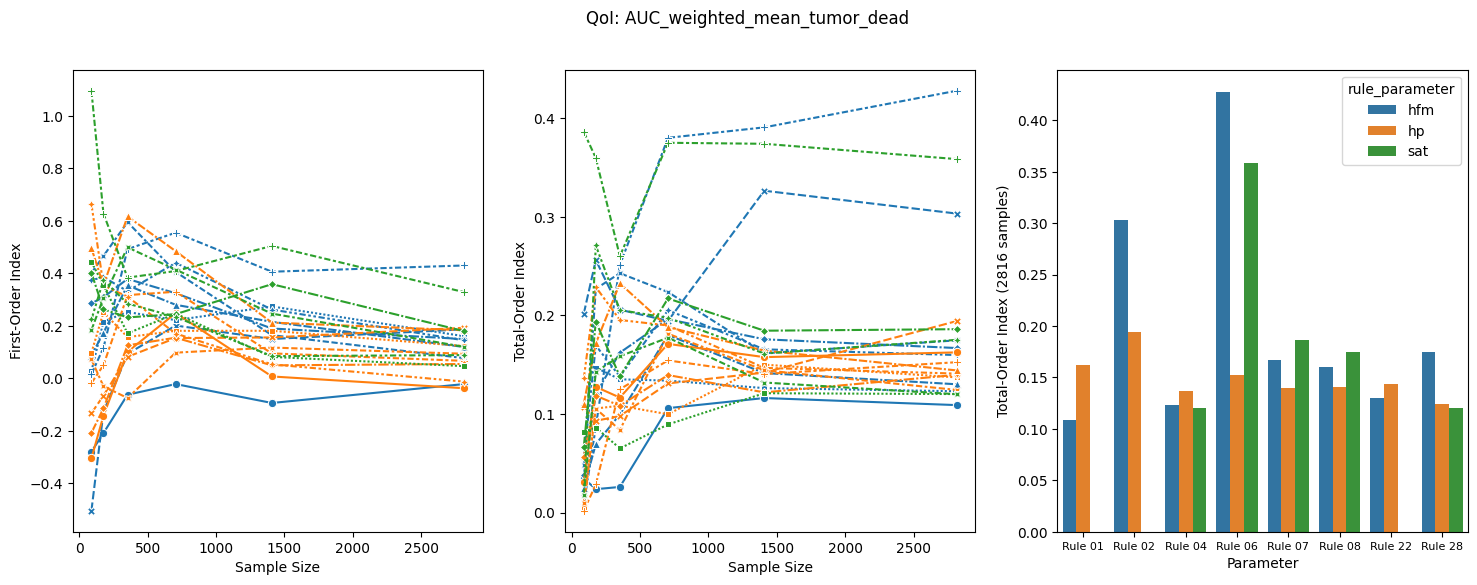

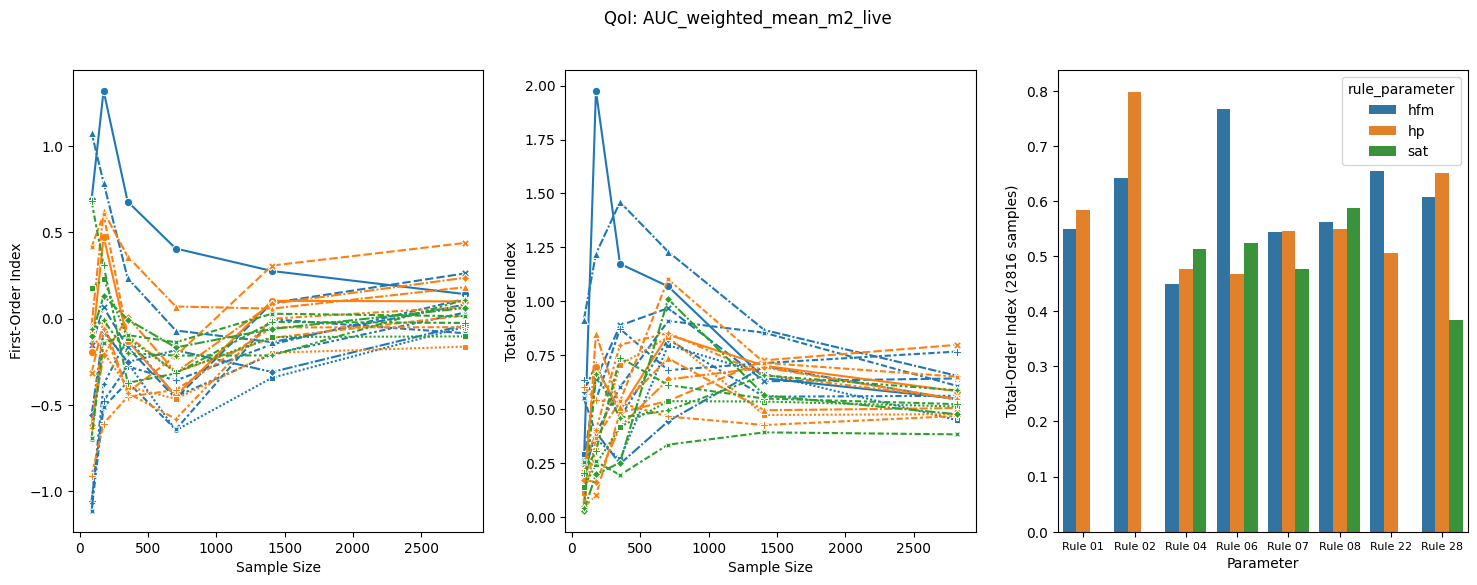

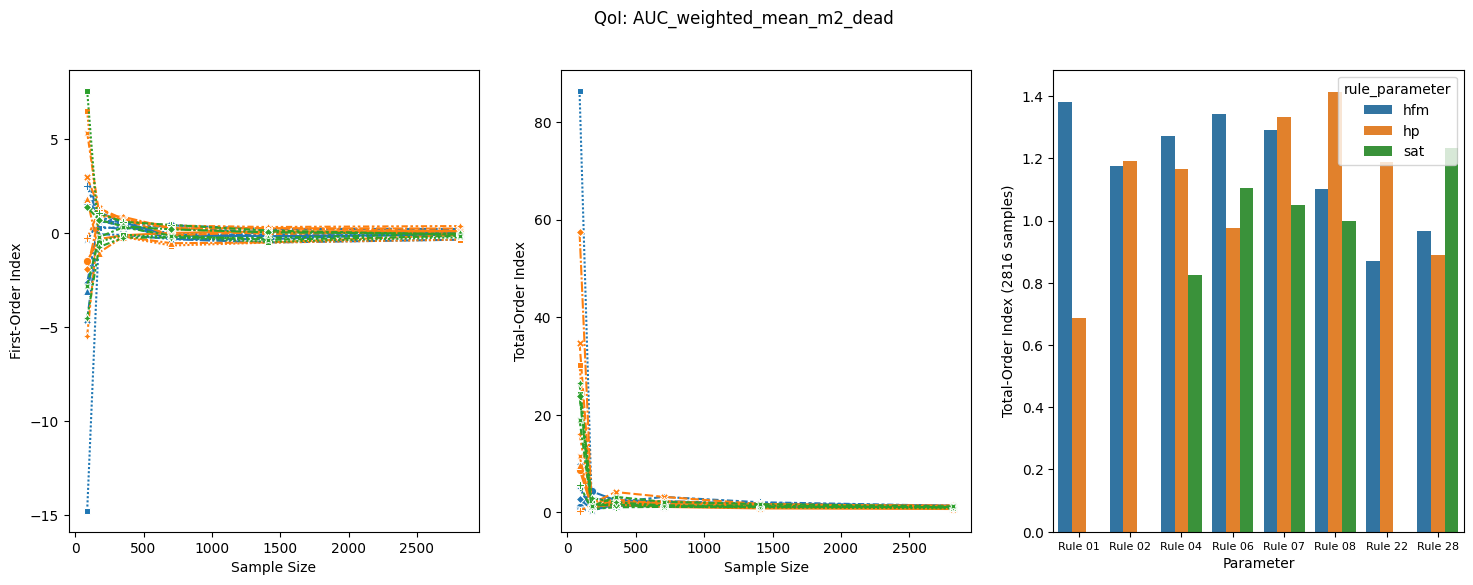

In [28]:
import seaborn as sns

for QOI in dic_analyzes.keys():
    if not np.isnan(dic_analyzes[QOI]['S1_values']).all():
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'QoI: {QOI}')
        
        # rank of 5 most important parameters
        rank_par_idx = np.argsort(dic_analyzes[QOI]['ST_values'][-1, :])[::-1][:5]
        top_parameters = np.array(problem["names"])[rank_par_idx]
        
        # Plotting the indices for each QOI
        df_temp = df_analyzes[ df_analyzes['QOI'] == QOI ]
        sns.lineplot(df_temp, x='sample_size', y='S1', hue='rule_parameter', style='rule_label', ax=axes[0], markers=True, legend=False)
        sns.lineplot(df_temp, x='sample_size', y='ST', hue='rule_parameter', style='rule_label', ax=axes[1], markers=True, legend=False)
        
        axes[0].set_xlabel('Sample Size')
        axes[0].set_ylabel('First-Order Index')
        
        axes[1].set_xlabel('Sample Size')
        axes[1].set_ylabel('Total-Order Index')
        
        sns.barplot(df_temp[ df_temp['sample_size'] == sample_sizes[-1] ], x='rule_label', y='ST', hue='rule_parameter', ax=axes[2])
        axes[2].tick_params(axis='x', labelsize=8)
        axes[2].set_xlabel('Parameter')
        axes[2].set_ylabel(f'Total-Order Index ({sample_sizes[-1]} samples)')
        
        plt.show()
    else:
        print(f'QoI: {QOI} has NaN values')

## Plot the QoIs: mean and std distance from center and AUC of population for each cell type

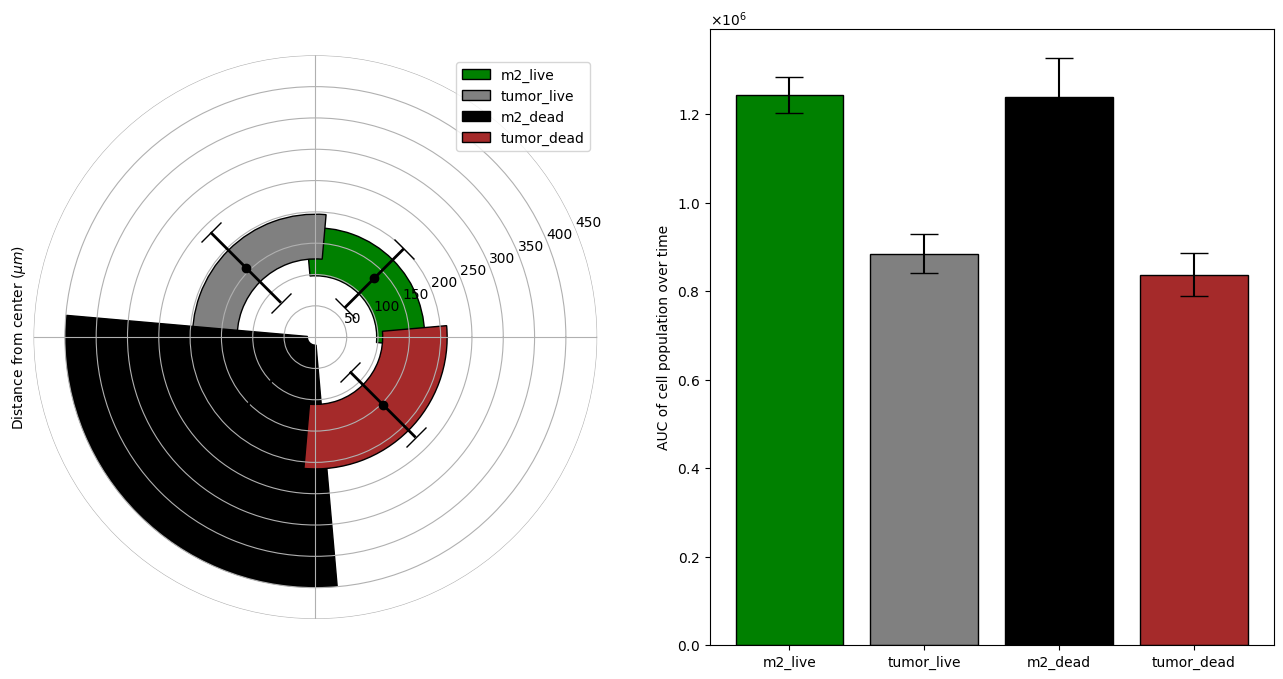

In [29]:
from matplotlib.ticker import FuncFormatter


pop_cols = ['m2_live', 'tumor_live', 'm2_dead', 'tumor_dead']
colors = ['green', 'gray' , 'black', 'brown']

radius_min = np.array([df_summary['dist_mean_'+pop_cols[0]].min(), df_summary['dist_mean_'+pop_cols[1]].min(), df_summary['dist_mean_'+pop_cols[2]].min(), df_summary['dist_mean_'+pop_cols[3]].min()])
radius_mean = np.array([df_summary['dist_mean_'+pop_cols[0]].mean(), df_summary['dist_mean_'+pop_cols[1]].mean(), df_summary['dist_mean_'+pop_cols[2]].mean(), df_summary['dist_mean_'+pop_cols[3]].mean()])
radius_max = np.array([df_summary['dist_mean_'+pop_cols[0]].max(), df_summary['dist_mean_'+pop_cols[1]].max(), df_summary['dist_mean_'+pop_cols[2]].max(), df_summary['dist_mean_'+pop_cols[3]].max()])
err_radius = np.array([df_summary['dist_std_'+pop_cols[0]].mean(), df_summary['dist_std_'+pop_cols[1]].mean(), df_summary['dist_std_'+pop_cols[2]].mean(),  df_summary['dist_std_'+pop_cols[3]].mean()])

theta = np.arange(0,2*np.pi,2*np.pi/len(pop_cols))
width = (2*np.pi/len(pop_cols)) + np.pi/18

aucs = np.array([df_summary['AUC_weighted_mean_'+pop_cols[0]].mean(), df_summary['AUC_weighted_mean_'+pop_cols[1]].mean(), df_summary['AUC_weighted_mean_'+pop_cols[2]].mean(), df_summary['AUC_weighted_mean_'+pop_cols[3]].mean()])
err_aucs = np.array([df_summary['AUC_weighted_mean_'+pop_cols[0]].std(), df_summary['AUC_weighted_mean_'+pop_cols[1]].std(), df_summary['AUC_weighted_mean_'+pop_cols[2]].std(), df_summary['AUC_weighted_mean_'+pop_cols[3]].std()])

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, polar=True)
ax2 = fig.add_subplot(122)

bars = ax1.bar(theta+np.pi/len(pop_cols), radius_max-radius_min, bottom=radius_min, color=colors, label=pop_cols, width=width, edgecolor='black')
bars_mean = ax1.errorbar(theta+np.pi/len(pop_cols), radius_mean, yerr=err_radius, fmt='o', color='black', ecolor='black', elinewidth=2, capsize=10)

ax1.set_ylim(0,450)
ax1.set_ylabel(r'Distance from center ($\mu m$)')
ax1.set_xticks(theta, labels=[])
ax1.spines['polar'].set_visible(False)

ax2.bar(pop_cols, aucs, yerr=err_aucs, capsize=10, color=colors, edgecolor='black')
ax2.set_ylabel('AUC of cell population over time')
ax2.yaxis.major.formatter._useMathText = True #(make x10^n)

ax1.legend()
plt.show()